# Fundamentals of Information Systems

## Python Programming (for Data Science)

### Master's Degree in Data Science

#### Giorgio Maria Di Nunzio
#### (Courtesy of Gabriele Tolomei FIS 2018-2019)
<a href="mailto:giorgiomaria.dinunzio@unipd.it">giorgiomaria.dinunzio@unipd.it</a><br/>
University of Padua, Italy<br/>
2021/2022<br/>

# Lecture 12: The Regression Problem - Example (Part 2)

In [5]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Import stats module from scipy, which contains a large number 
# of probability distributions as well as an exhaustive library of statistical functions.
import scipy.stats as stats
# Import the sub-module 'linear_model' of scikit-learn
# this sub-module implements generalized linear models.
# API: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model
from sklearn import linear_model
# Import two quality metrics which will be used to assess the quality
# of our predictions: MSE and R squared (a.k.a. coefficient of determination)
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

# Summary of Part 1

In [6]:
# Path to the local dataset file
DATASET_PATH = "../data/auto-mpg-regression/dataset.tsv"

## Loading Dataset

In [7]:
columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 
           'acceleration', 'model_year', 'origin', 'car_name']

data = pd.read_csv(DATASET_PATH, sep="\t", header=None, 
                   names=columns,
                  na_values={'horsepower':'?'})

print("Shape of the dataset: {}".format(data.shape))
data.head()

Shape of the dataset: (398, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


## Change the Column Layout

In [8]:
# Just as a convention, I prefer to place the column to be predicted
# as the last one.
columns = data.columns.tolist()
# Popping out 'mpg' from the list and insert it back at the end.
columns.insert(len(columns), columns.pop(columns.index('mpg')))
# Let's refactor the DataFrame using this new column index
data = data.loc[:, columns]
data.head()
# Alternatively to 'loc' we can also use 'reindex()'
# data = data.reindex(columns=columns)
# data.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,mpg
0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,18.0
1,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320,15.0
2,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite,18.0
3,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst,16.0
4,8,302.0,140.0,3449.0,10.5,70,1,ford torino,17.0


## Apply Some Simple Data Transformations

In [9]:
# Suppose we want to convert displacement unit from cubic inch to litre
# There is a useful conversion table which tells us how to do that.
# 1 cubic inch = 0.016387064 litre
CI_TO_LITRE = 0.016387064
data.displacement *= CI_TO_LITRE
data.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,mpg
0,8,5.030829,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,18.0
1,8,5.735472,165.0,3693.0,11.5,70,1,buick skylark 320,15.0
2,8,5.211086,150.0,3436.0,11.0,70,1,plymouth satellite,18.0
3,8,4.981667,150.0,3433.0,12.0,70,1,amc rebel sst,16.0
4,8,4.948893,140.0,3449.0,10.5,70,1,ford torino,17.0


## Handling Missing Values (NA)

In [10]:
# Let's replace missing values on 'horsepower'
# using the median as computed from the other observations.
# NOTE: here's a classical example where using the mean rather than the median
# might affect the result, as the mean is more sensitive to outliers.
# NOTE: by default, median() does not include NAs in the computation.
# In other words, we don't need to explicitly tell pandas to work on non-NA values:
# data.horsepower[data.horsepower.notnull()].median()
data.horsepower.fillna(data.horsepower.median(), inplace=True)
data.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,mpg
0,8,5.030829,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,18.0
1,8,5.735472,165.0,3693.0,11.5,70,1,buick skylark 320,15.0
2,8,5.211086,150.0,3436.0,11.0,70,1,plymouth satellite,18.0
3,8,4.981667,150.0,3433.0,12.0,70,1,amc rebel sst,16.0
4,8,4.948893,140.0,3449.0,10.5,70,1,ford torino,17.0


## Handling Outliers

In [11]:
# Let's winsorize 'horsepower' and 'acceleration'
_ = stats.mstats.winsorize(data.horsepower, limits=0.0375, inplace=True)
_ = stats.mstats.winsorize(data.acceleration, limits=0.0375, inplace=True)

## Encoding Categorical Features: One-Hot Encoding

In [12]:
# In pandas we can achieve easily one-hot encoding using the 'get_dummies()' function
categorical_features = ['cylinders', 'model_year', 'origin']
data = pd.get_dummies(data, columns = categorical_features)
data.head()

,displacement,horsepower,weight,acceleration,car_name,mpg,cylinders_3,cylinders_4,cylinders_5,cylinders_6,...,model_year_76,model_year_77,model_year_78,model_year_79,model_year_80,model_year_81,model_year_82,origin_1,origin_2,origin_3
0,5.030829,130.0,3504.0,12.0,chevrolet chevelle malibu,18.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,5.735472,165.0,3693.0,11.5,buick skylark 320,15.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,5.211086,150.0,3436.0,11.0,plymouth satellite,18.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4.981667,150.0,3433.0,12.0,amc rebel sst,16.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,4.948893,140.0,3449.0,11.0,ford torino,17.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [13]:
# Just as a convention, I prefer to place the column to be predicted
# as the last one.
columns = data.columns.tolist()
# Popping out 'mpg' from the list and insert it back at the end.
columns.insert(len(columns), columns.pop(columns.index('mpg')))
# Let's refactor the DataFrame using this new column index
data = data.loc[:, columns]
data.head()

,displacement,horsepower,weight,acceleration,car_name,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,...,model_year_77,model_year_78,model_year_79,model_year_80,model_year_81,model_year_82,origin_1,origin_2,origin_3,mpg
0,5.030829,130.0,3504.0,12.0,chevrolet chevelle malibu,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,18.0
1,5.735472,165.0,3693.0,11.5,buick skylark 320,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,15.0
2,5.211086,150.0,3436.0,11.0,plymouth satellite,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,18.0
3,4.981667,150.0,3433.0,12.0,amc rebel sst,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,16.0
4,4.948893,140.0,3449.0,11.0,ford torino,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,17.0


In [14]:
def sanitize_automaker_name(car_name):
    s = car_name.split(' ')[0]
    if s == 'vw' or s == 'vokswagen':
        return car_name.replace(s,'volkswagen')
    if s == 'chevroelt' or s == 'chevy':
        return car_name.replace(s,'chevrolet')
    if s == 'maxda':
        return car_name.replace(s,'mazda')
    if s == 'mercedes':
        return car_name.replace(s,'mercedes-benz')
    if s == 'toyouta':
        return car_name.replace(s,'toyota')
    return car_name

In [15]:
"""
Let's sanitize automaker name on 'car_name' column
"""
data['car_name'] = data['car_name'].map(lambda x: sanitize_automaker_name(x))
data.head()

,displacement,horsepower,weight,acceleration,car_name,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,...,model_year_77,model_year_78,model_year_79,model_year_80,model_year_81,model_year_82,origin_1,origin_2,origin_3,mpg
0,5.030829,130.0,3504.0,12.0,chevrolet chevelle malibu,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,18.0
1,5.735472,165.0,3693.0,11.5,buick skylark 320,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,15.0
2,5.211086,150.0,3436.0,11.0,plymouth satellite,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,18.0
3,4.981667,150.0,3433.0,12.0,amc rebel sst,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,16.0
4,4.948893,140.0,3449.0,11.0,ford torino,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,17.0


In [16]:
"""
Three solutions can be designed to tackle with this issue:
1) Just drop the column 'car_name' (i.e., our model won't rely on that feature for prediction)
2) Use one-hot encoding scheme and deal with sparsity data (i.e., possibly leading to overfitting)
3) Trade-off: try to build another column which somehow reduces (i.e., cluster) similar values together
and then apply one-hot encoding.
Let's see how to perform 3)
"""
# Suppose we want to create another column called 'automaker_name', which simply contains
# the name of the automaker, disregarding the model.
# For example, automaker_name('ford gran torino') = automaker_name('ford f250') = 'ford'
data['automaker_name'] = data['car_name'].map(lambda x: x.split(' ')[0])
data.head()

,displacement,horsepower,weight,acceleration,car_name,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,...,model_year_78,model_year_79,model_year_80,model_year_81,model_year_82,origin_1,origin_2,origin_3,mpg,automaker_name
0,5.030829,130.0,3504.0,12.0,chevrolet chevelle malibu,0,0,0,0,1,...,0,0,0,0,0,1,0,0,18.0,chevrolet
1,5.735472,165.0,3693.0,11.5,buick skylark 320,0,0,0,0,1,...,0,0,0,0,0,1,0,0,15.0,buick
2,5.211086,150.0,3436.0,11.0,plymouth satellite,0,0,0,0,1,...,0,0,0,0,0,1,0,0,18.0,plymouth
3,4.981667,150.0,3433.0,12.0,amc rebel sst,0,0,0,0,1,...,0,0,0,0,0,1,0,0,16.0,amc
4,4.948893,140.0,3449.0,11.0,ford torino,0,0,0,0,1,...,0,0,0,0,0,1,0,0,17.0,ford


In [17]:
# Create the set of the top-10 automakers
top_10_automakers = set(data['automaker_name'].value_counts()[:10].index)
# Label with 'other' any automaker_name which is not in the list above
data['automaker_name'] = np.where(data['automaker_name'].isin(top_10_automakers), 
                                               data['automaker_name'],
                                              'other')

In [18]:
categorical_features = ['automaker_name']
data = pd.get_dummies(data, columns = categorical_features)
data.head()

,displacement,horsepower,weight,acceleration,car_name,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,...,automaker_name_buick,automaker_name_chevrolet,automaker_name_datsun,automaker_name_dodge,automaker_name_ford,automaker_name_other,automaker_name_plymouth,automaker_name_pontiac,automaker_name_toyota,automaker_name_volkswagen
0,5.030829,130.0,3504.0,12.0,chevrolet chevelle malibu,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
1,5.735472,165.0,3693.0,11.5,buick skylark 320,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,5.211086,150.0,3436.0,11.0,plymouth satellite,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,4.981667,150.0,3433.0,12.0,amc rebel sst,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,4.948893,140.0,3449.0,11.0,ford torino,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [19]:
# Just as a convention, I prefer to place the column to be predicted
# as the last one.
columns = data.columns.tolist()
# Popping out 'mpg' from the list and insert it back at the end.
columns.insert(len(columns), columns.pop(columns.index('mpg')))
# Popping out 'automaker_name_other' from the list and insert it after 'automaker_name_volkswagen'.
columns.insert(columns.index('automaker_name_volkswagen'), columns.pop(columns.index('automaker_name_other')))
# Popping out 'car_name' from the list and insert it right before 'mpg'
columns.insert(-1, columns.pop(columns.index('car_name')))
# Let's refactor the DataFrame using this new column index
data = data.loc[:, columns]
data.head()

,displacement,horsepower,weight,acceleration,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,model_year_70,...,automaker_name_datsun,automaker_name_dodge,automaker_name_ford,automaker_name_plymouth,automaker_name_pontiac,automaker_name_toyota,automaker_name_volkswagen,automaker_name_other,car_name,mpg
0,5.030829,130.0,3504.0,12.0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,chevrolet chevelle malibu,18.0
1,5.735472,165.0,3693.0,11.5,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,buick skylark 320,15.0
2,5.211086,150.0,3436.0,11.0,0,0,0,0,1,1,...,0,0,0,1,0,0,0,0,plymouth satellite,18.0
3,4.981667,150.0,3433.0,12.0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,amc rebel sst,16.0
4,4.948893,140.0,3449.0,11.0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,ford torino,17.0


# 4. Building a Predictive Model

# 4.1 Dataset Splitting: _Training_ vs. _Test_

In [20]:
"""
Extract the feature matrix from our original DataFrame.
"""
# Feature matrix X is composed of all the columns 
# except 'car_name' and 'mpg' (i.e., the target)
X = data.iloc[:,:-2]
X.head()

,displacement,horsepower,weight,acceleration,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,model_year_70,...,automaker_name_buick,automaker_name_chevrolet,automaker_name_datsun,automaker_name_dodge,automaker_name_ford,automaker_name_plymouth,automaker_name_pontiac,automaker_name_toyota,automaker_name_volkswagen,automaker_name_other
0,5.030829,130.0,3504.0,12.0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
1,5.735472,165.0,3693.0,11.5,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
2,5.211086,150.0,3436.0,11.0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
3,4.981667,150.0,3433.0,12.0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,4.948893,140.0,3449.0,11.0,0,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0


In [21]:
"""
Similarly, we want to extract the target column vector y.
"""
y = data.mpg
y.head()

0    18.0
1    15.0
2    18.0
3    16.0
4    17.0
Name: mpg, dtype: float64

In [51]:
"""
Let's split our dataset with scikit-learn 'train_test_split' function, 
which splits the input dataset into training and test set, respectively.
We want the training set to account for 80% of the original dataset, whilst 
the test set to account for the remaining 20%.
Additionally, we would like to take advantage of stratified sampling,
so as to obtain the same target distribution in both the training and the test sets.
PROBLEM: When target (y) is categorical this is straightforward (just use 'stratify=y').
If y is continous, instead, we need to 'discretize' it before use stratified sampling.
"""

"\nLet's split our dataset with scikit-learn 'train_test_split' function, \nwhich splits the input dataset into training and test set, respectively.\nWe want the training set to account for 80% of the original dataset, whilst \nthe test set to account for the remaining 20%.\nAdditionally, we would like to take advantage of stratified sampling,\nso as to obtain the same target distribution in both the training and the test sets.\nPROBLEM: When target (y) is categorical this is straightforward (just use 'stratify=y').\nIf y is continous, instead, we need to 'discretize' it before use stratified sampling.\n"

In [22]:
# 1. Check the number of observations contained in 'y'.
print("N. of observations = {}".format(y.shape[0]))

# 2. Suppose we want to use the Friedman-Diaconis rule to devise the number of bins.
# bin_width = 2 * IQR/n^{1/3}; n_bins = (max - min)/bin_width
y_q1, y_q3 = y.quantile([.25, .75])
print("1st quartile = {:.2f}".format(y_q1))
print("3rd quartile = {:.2f}".format(y_q3))
y_IQR = (y_q3 - y_q1)
bin_width = 2 * y_IQR/math.pow(y.shape[0], 1/3)
n_bins = int((y.max() - y.min())//bin_width)
print("N. of bins = {}".format(n_bins))

# 3. Save our y values in a new ndarray,
# broken down by the bins created above.
bins = np.linspace(0, y.shape[0], n_bins)
y_binned = np.digitize(y, bins)

N. of observations = 398
1st quartile = 17.50
3rd quartile = 29.00
N. of bins = 12


In [23]:
y_binned

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [24]:
unique, counts = np.unique(y_binned, return_counts=True)
counts

array([374,  24])

In [25]:
from sklearn.model_selection import train_test_split
# 4. Pass y_binned to the stratify argument,
# and sklearn will handle the rest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y_binned)

In [26]:
print("Training Set shape: {}".format(X_train.shape))
print("Test Set shape: {}".format(X_test.shape))

Training Set shape: (318, 36)
Test Set shape: (80, 36)


## Feature Scaling: Why/When

-  <span style="color: red">**REMEMBER:**</span> Not every learning models are sensitive to different feature scales! 

-  For example, in the case of Linear Regression the vector of model parameters we come up with when we minimize the MSE - using either the pseudo-inverse (closed-form) or gradient descent (iterative) solution - is **not** affected by different feature scales, except for a constant.

-  You can convince yourself of this by computing the gradient of MSE using non-scaled and scaled features.

-  Other models, instead, are not invariant with respect to scalar transformations of the input (features), and leads to completely different results if features are not properly scaled. 

## Feature Scaling: How

-  Feature scaling **cannot** be done looking at the whole dataset!

-  In other words, either you standardize (using **z-scores**) or normalize (using **min-max**) your features you **must** do it considering only the training set portion of your dataset.

-  The same scaling, then, should be applied to the test set.

In [27]:
"""
Let's use two different feature scaling strategies: standard z-scores and min-max
"""
# The following is the scikit-learn package which provides
# various preprocessing capabilities
from sklearn import preprocessing

In [28]:
# Standardizing features using z-score
std_scaler = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scaler.transform(X_train)
# Alternatively, using pure pandas:
# X_train_mean = X_train.mean()
# X_train_std = X_train.std()
# X_train_std = (X_train - X_train_mean)/X_train_std

# Normalizing features using min-max
minmax_scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train_minmax = minmax_scaler.transform(X_train)
# Alternatively, using pure pandas:
# X_train_max = X_train.max()
# X_train_min = X_train.min()
# X_train_minmax = (X_train - X_train_min)/(X_train_max - X_train_min)

In [29]:
"""
At this stage, we can work with 3 different feature matrices:
- The original one: X_train
- The standardized one: X_train_std
- The min-max normalized one: X_train_minmax
"""

'\nAt this stage, we can work with 3 different feature matrices:\n- The original one: X_train\n- The standardized one: X_train_std\n- The min-max normalized one: X_train_minmax\n'

In [30]:
"""
General function used to fit a given model to a training set (X_train, y_train)
"""
def fit(model, X_train, y_train):
    model.fit(X_train, y_train)

In [31]:
"""
General function used to make predictions on the test set (X_test)
"""
def predictions(model, X_test):
    return model.predict(X_test)

In [32]:
"""
General function used to assess the quality of predictions
in terms of two scores: MSE and R2
"""
def evaluate(true_values, predicted_values):
    # The mean squared error
    print("Mean Squared Error (MSE) = {:.6f}".
          format(mean_squared_error(true_values, predicted_values)))
    # Explained variance score: 1 is perfect prediction
    print("Coefficient of Determination (R2 score) = {:.6f}".
          format(r2_score(true_values, predicted_values)))

In [52]:
def print_regression_coefficients(model, columns):
    print(
        "Regression Coefficients:\n{}".format(
            "\n".join(
                [
                    "[" +
                    columns[i].strip() +
                    "={:.2f}".format(
                        model.coef_[i]) +
                    "]" for i in range(
                        0,
                        len(columns))])))


In [53]:
def plot_true_vs_predicted(y_true, y_predicted):
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_predicted, edgecolors=(0, 0, 0), color='red')
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    ax.set_xlabel('True MPG')
    ax.set_ylabel('Predicted MPG')

***** Evaluate Predictions on Training Set *****
Mean Squared Error (MSE) = 6.391591
Coefficient of Determination (R2 score) = 0.892066

***** Evaluate Predictions on Test Set *****
Mean Squared Error (MSE) = 10.570942
Coefficient of Determination (R2 score) = 0.842210


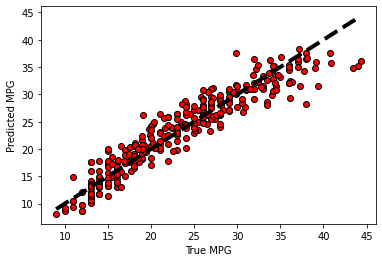

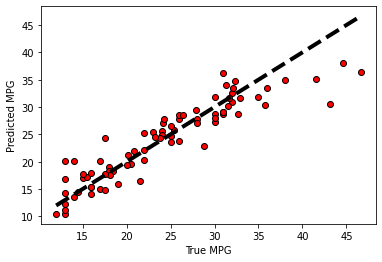

In [54]:
# Create linear regression object
model = linear_model.LinearRegression()

# 1. Try to fit this linear regressor to our original training set
fit(model, X_train, y_train)
# 2. Assess the quality of predictions made on the same training set
print("***** Evaluate Predictions on Training Set *****")
mpg_y_train_pred = model.predict(X_train)
evaluate(y_train, mpg_y_train_pred)
plot_true_vs_predicted(y_train, mpg_y_train_pred)
print()
# 3. Assess the quality of predictions made on the test set
print("***** Evaluate Predictions on Test Set *****")
mpg_y_test_pred = model.predict(X_test)
evaluate(y_test, mpg_y_test_pred)
plot_true_vs_predicted(y_test, mpg_y_test_pred)

Mean Squared Error (MSE) = 10.571293
Coefficient of Determination (R2 score) = 0.842204


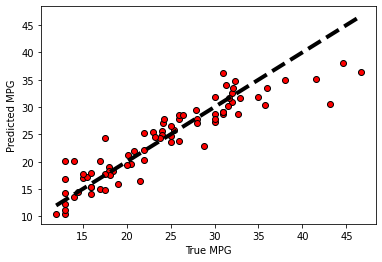

In [55]:
# Create another linear regression object
model_std = linear_model.LinearRegression()

# 1. Try to fit this linear regressor to our original training set
fit(model_std, X_train_std, y_train)
# 2. Scale the test set (using the same scaler fit to the training set)
X_test_std = std_scaler.transform(X_test)
#X_test_std = (X_test - X_train_mean)/X_train_std
# 3. Make predictions using the testing set
mpg_y_pred_std = model_std.predict(X_test_std)
# 4. Evaluate predictions
evaluate(y_test, mpg_y_pred_std)
# 5. Plot true vs. predicted values of 'mpg'
plot_true_vs_predicted(y_test, mpg_y_pred_std)

Mean Squared Error (MSE) = 10.570942
Coefficient of Determination (R2 score) = 0.842210


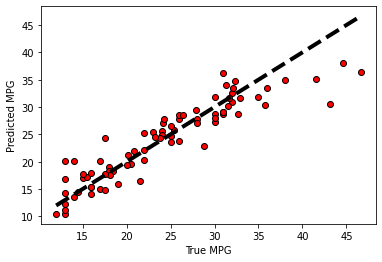

In [56]:
# Create another linear regression object
model_minmax = linear_model.LinearRegression()

# 1. Try to fit this linear regressor to our original training set
fit(model_minmax, X_train_minmax, y_train)
# 2. Scale the test set (using the same scaler fit to the training set)
X_test_minmax = minmax_scaler.transform(X_test)
#X_test_minmax = (X_test - X_train_min)/X_train_max
# 3. Make predictions using the testing set
mpg_y_pred_minmax = model_minmax.predict(X_test_minmax)
# 4. Evaluate predictions
evaluate(y_test, mpg_y_pred_minmax)
# 5. Plot true vs. predicted values of 'mpg'
plot_true_vs_predicted(y_test, mpg_y_pred_minmax)

## Feature Selection

In [57]:
"""
From the last lecture, we have identified the subset of features,
which correlate the most with the target 'mpg' variable.
"""
corr_matrix = data.corr()
strong_corr = corr_matrix[(corr_matrix['mpg'].abs() > .5) &
                         (corr_matrix['mpg'] != 1)].loc[:, 'mpg']

print("Strongest correlated features:\n{}".
      format(strong_corr.sort_values()))
print()
print("Strongest correlated features (absolute values):\n{}".
      format(strong_corr.abs().sort_values(ascending=False)))

Strongest correlated features:
weight         -0.831741
displacement   -0.804203
horsepower     -0.788402
cylinders_8    -0.647308
origin_1       -0.568192
cylinders_4     0.758259
Name: mpg, dtype: float64

Strongest correlated features (absolute values):
weight          0.831741
displacement    0.804203
horsepower      0.788402
cylinders_4     0.758259
cylinders_8     0.647308
origin_1        0.568192
Name: mpg, dtype: float64


In [58]:
corr_matrix = data.corr()
corr_matrix[(corr_matrix['mpg'].abs() > .5) & (corr_matrix['mpg'] != 1)].loc[:, 'mpg']

displacement   -0.804203
horsepower     -0.788402
weight         -0.831741
cylinders_4     0.758259
cylinders_8    -0.647308
origin_1       -0.568192
Name: mpg, dtype: float64

In [59]:
"""
Let's select from the whole training set (X_train) and test set (X_test)
only those features above.
"""
X_train_reduced = X_train[strong_corr.index]
X_test_reduced = X_test[strong_corr.index]

Mean Squared Error (MSE) = 21.177612
Coefficient of Determination (R2 score) = 0.683886


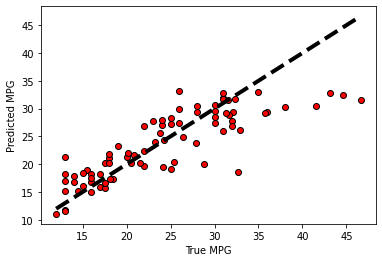

In [60]:
"""
Train our linear regression model only on this subset of features.
"""
# Create another linear regression object
model_reduced = linear_model.LinearRegression()

# 1. Try to fit this linear regressor to our original training set
fit(model_reduced, X_train_reduced, y_train)
# 2. Make predictions using the testing set
mpg_y_pred_reduced = model_reduced.predict(X_test_reduced)
# 3. Evaluate predictions
evaluate(y_test, mpg_y_pred_reduced)
# 4. Plot true vs. predicted values of 'mpg'
plot_true_vs_predicted(y_test, mpg_y_pred_reduced)

In [61]:
"""
R2 score suffers from an intrinsic issue:
It automatically and spuriously increases when extra explanatory variables are added to the model.
To overcome this problem, 'adjusted R2' is used, instead.

adj_R2 = R2 - (1 - R2) * (p - 1)/(n - p)

where p is the total number of explanatory variables in the model (not including the constant term), 
and n is the sample size.
"""

def adjusted_r2_score(r2, p, n):
    return r2 - (1 - r2) * (p - 1)/(n - p)

In [62]:
print("***** Fully trained linear regression model *****")
r2_full = r2_score(y_test, mpg_y_test_pred)
p_full = len(model.coef_)
n = X_test.shape[0]
print("- N. of test samples: {}".format(n))
print("- N. of predictors (i.e., features): {}".format(p_full))
print("- R2 score: {:.2f}".format(r2_full))
print("***** Reduced linear regression model *****")
r2_reduced = r2_score(y_test, mpg_y_pred_reduced)
p_reduced = len(model_reduced.coef_)
print("- N. of test samples: {}".format(n))
print("- N. of predictors (i.e., features): {}".format(p_reduced))
print("- R2 score: {:.2f}".format(r2_reduced))
print("-----------------------------------------------------")
print("Adjusted R2 score (fully-trained model): {:.2f}"
      .format(adjusted_r2_score(r2_full, p_full, n)))
print("Adjusted R2 score (reduced model): {:.2f}"
      .format(adjusted_r2_score(r2_reduced, p_reduced, n)))

***** Fully trained linear regression model *****
- N. of test samples: 80
- N. of predictors (i.e., features): 36
- R2 score: 0.84
***** Reduced linear regression model *****
- N. of test samples: 80
- N. of predictors (i.e., features): 6
- R2 score: 0.68
-----------------------------------------------------
Adjusted R2 score (fully-trained model): 0.72
Adjusted R2 score (reduced model): 0.66


## $k$-fold Cross Validation

In [63]:
"""
Instead of splitting training and test set, we can use k-fold cross validation.
NOTE: Since there is no need for hyperparameter tuning here,
we can simply run k-fold cross validation on the whole dataset (X)
'cross_val_score' is a function which gives us the cv scores
(R2 is the default score for linear regression).
"""
from sklearn.model_selection import cross_val_score
# Reset the linear regression object
cv_model = linear_model.LinearRegression()

# Run 'cross_val_score' to get the R2 score on each fold
# NOTE: cross validation is performed on the whole dataset as there is no
# need for hyperparameter tuning at this stage, nor model comparison.
cv_scores = cross_val_score(cv_model, X, y, cv=10)

print("***** Cross Validation Summary *****")
for v in range(0, len(cv_scores)):
    print("R2 score on fold-{} = [{}]".format(v+1, cv_scores[v]))

***** Cross Validation Summary *****
R2 score on fold-1 = [0.6147700468198161]
R2 score on fold-2 = [0.8578432248160668]
R2 score on fold-3 = [0.7623781179352239]
R2 score on fold-4 = [0.8193522080779387]
R2 score on fold-5 = [0.7152008355108621]
R2 score on fold-6 = [0.8352881782262789]
R2 score on fold-7 = [0.6814313255785469]
R2 score on fold-8 = [0.7016084192191416]
R2 score on fold-9 = [0.3430506946108738]
R2 score on fold-10 = [0.030284777740592905]


In [64]:
print("Average 10-fold cross validation R2 score: {:.2f} (+/- {:.2f})"
      .format(cv_scores.mean(), cv_scores.std()))

Average 10-fold cross validation R2 score: 0.64 (+/- 0.25)


In [65]:
"""
By default, no shuffling is performed before data splitting.
We can override this behavior using a specific instance of KFold class.
"""
from sklearn.model_selection import KFold
# Reset the linear regression object
cv_model = linear_model.LinearRegression()

# Run 'cross_val_score' to get the R2 score on each fold
cv_scores = cross_val_score(cv_model, X, y, cv=KFold(n_splits=10, 
                                                     shuffle=True, random_state=42))

print("***** Cross Validation Summary *****")
for v in range(0, len(cv_scores)):
    print("R2 score on fold-{} = [{}]".format(v+1, cv_scores[v]))

***** Cross Validation Summary *****
R2 score on fold-1 = [0.8685438627561608]
R2 score on fold-2 = [0.8790081690850898]
R2 score on fold-3 = [0.8701838448746344]
R2 score on fold-4 = [0.8817313681120706]
R2 score on fold-5 = [0.8768312703800574]
R2 score on fold-6 = [0.8550118543751072]
R2 score on fold-7 = [0.8118375370238045]
R2 score on fold-8 = [0.8800040343353152]
R2 score on fold-9 = [0.8068558383615352]
R2 score on fold-10 = [0.8768646908165746]


In [66]:
print("Average 10-fold cross validation R2 score (with random shuffling): {:.2f} (+/- {:.2f})"
      .format(cv_scores.mean(), cv_scores.std()))

Average 10-fold cross validation R2 score (with random shuffling): 0.86 (+/- 0.03)


In [67]:
"""
Instead of splitting training and test set, we can use k-fold cross validation.
NOTE: Since there is no need for hyperparameter tuning here,
we can simply run k-fold cross validation on the whole dataset (X)
'cross_validate' is a function which gives us a dictionary of scores.
"""
from sklearn.model_selection import cross_validate
# Reset the linear regression object
cv_model = linear_model.LinearRegression()

scoring = ['r2']
cv_scores = cross_validate(cv_model, X, y, scoring=scoring, 
                           cv=KFold(n_splits=10, shuffle=True, random_state=42), 
                           return_train_score=True)
print("***** Cross Validation Summary *****")
for k in cv_scores:
    print("{} = [{}]".format(k, ", ".join(["{:.5f}".format(v) for v in cv_scores[k]])))

***** Cross Validation Summary *****
fit_time = [0.00750, 0.01346, 0.01275, 0.01307, 0.00595, 0.00788, 0.00757, 0.01059, 0.01939, 0.01046]
score_time = [0.00185, 0.00178, 0.00195, 0.00207, 0.00222, 0.00204, 0.00234, 0.00189, 0.00290, 0.00254]
test_r2 = [0.86854, 0.87901, 0.87018, 0.88173, 0.87683, 0.85501, 0.81184, 0.88000, 0.80686, 0.87686]
train_r2 = [0.88516, 0.88389, 0.88416, 0.88283, 0.88361, 0.88583, 0.89461, 0.88286, 0.88959, 0.88390]


Mean Squared Error (MSE) = 8.546446
Coefficient of Determination (R2 score) = 0.859747


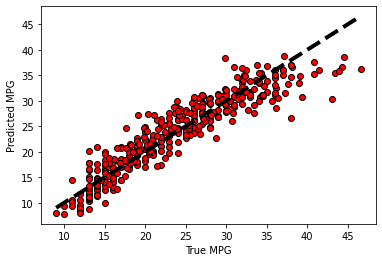

In [68]:
"""
Use the outcome of k-fold cross validation to generate predictions, 
calling 'cross_val_predict' function.
"""
from sklearn.model_selection import cross_val_predict

# Reset the linear regression object
cv_model = linear_model.LinearRegression()
# We generate predictions on the basis of the result of 10-fold cv
mpg_y_pred_cv = cross_val_predict(cv_model, X, y, cv=KFold(n_splits=10, 
                                                           shuffle=True, random_state=42))
# Evaluate predictions
evaluate(y, mpg_y_pred_cv)
# Plot true vs. predicted values (using 10-fold cross validation)
plot_true_vs_predicted(y, mpg_y_pred_cv)

Mean Squared Error (MSE) = 8.515419
Coefficient of Determination (R2 score) = 0.860257


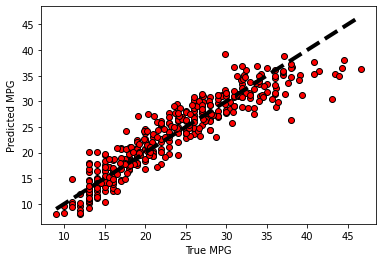

In [69]:
"""
Leave-One-Out cross validation (i.e., k = n, number of observations)
"""
from sklearn.model_selection import cross_val_predict

# Reset the linear regression object
cv_model = linear_model.LinearRegression()
# We generate predictions on the basis of the result of leave-one-out
mpg_y_pred_cv = cross_val_predict(cv_model, X, y, cv=X.shape[0])
# Evaluate predictions
evaluate(y, mpg_y_pred_cv)
# Plot true vs. predicted values (using leave-one-out cross validation)
plot_true_vs_predicted(y, mpg_y_pred_cv)